# **Installations Required**

In [ ]:
# Installations
!pip install adversarial-robustness-toolbox
!pip install tensorflow==2.13.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 25.4 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: gast
  

# **Imports for dataset loading, declaring the model and the MIA attack**

In [ ]:
# Imports

# for dataset
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# for model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
import keras.backend as k

# for attack
import warnings
import numpy as np
import tensorflow as tf
from numpy.random import seed
from art.estimators.classification import KerasClassifier
from art.attacks.inference.model_inversion.mi_face import MIFace
import matplotlib.pyplot as plt

tf.compat.v1.disable_eager_execution()
warnings.filterwarnings('ignore')
seed(123)

# **Data Preprocessing**
*   Load MNIST Dataset
*   In federated learning, each client will have different datasets
*   Client1 - First 5 labels of MNIST
*   Client2 - Last 5 labels of MNIST
*   After loading the datasets, we have printed the shapes of dataset, and first 5 samples of the dataset for client1 and client2

Trainset 1 shape: (30596, 28, 28, 1), Trainset 2 shape: (29404, 28, 28, 1)
Testset 1 shape: (5139, 28, 28, 1), Testset 2 shape: (4861, 28, 28, 1)


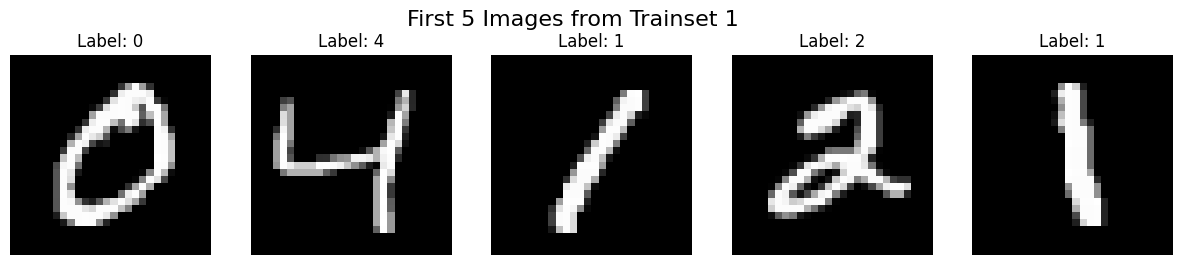

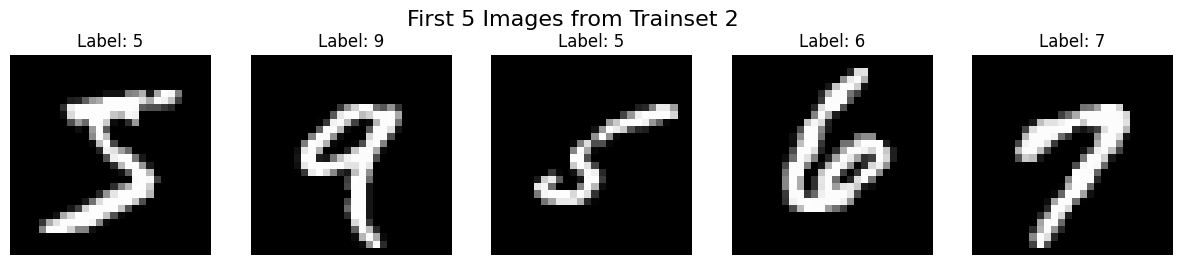

In [ ]:
# Data Preprocessing

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize and expand dimensions for channels
x_train = x_train.astype('float32') / 255.0
x_train = x_train[..., np.newaxis]  # Add channel dimension
x_test = x_test.astype('float32') / 255.0
x_test = x_test[..., np.newaxis]  # Add channel dimension

# Convert labels to categorical (one-hot encoded)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
# Convert one-hot encoded labels to class indices
y_train_classes = np.argmax(y_train, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Train set
# Split the MNIST training set based on the first 5 and second 5 labels
trainset1_indices = np.isin(y_train_classes, [0, 1, 2, 3, 4])  # First 5 labels
trainset2_indices = np.isin(y_train_classes, [5, 6, 7, 8, 9])  # Second 5 labels
x_train_set1 = x_train[trainset1_indices]
y_train_set1 = y_train[trainset1_indices]
x_train_set2 = x_train[trainset2_indices]
y_train_set2 = y_train[trainset2_indices]

# Test set
# Split the MNIST test set based on the first 5 and second 5 labels
testset1_indices = np.isin(y_test_classes, [0, 1, 2, 3, 4])  # First 5 labels
testset2_indices = np.isin(y_test_classes, [5, 6, 7, 8, 9])  # Second 5 labels
x_test_set1 = x_test[testset1_indices]
y_test_set1 = y_test[testset1_indices]
x_test_set2 = x_test[testset2_indices]
y_test_set2 = y_test[testset2_indices]

# Print the shape of the datasets to verify
print(f"Trainset 1 shape: {x_train_set1.shape}, Trainset 2 shape: {x_train_set2.shape}")
print(f"Testset 1 shape: {x_test_set1.shape}, Testset 2 shape: {x_test_set2.shape}")

# Function to plot images
def plot_images(images, labels, title, num_images=5):
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Label: {np.argmax(labels[i])}")  # Display the label
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()
# Plot the first 5 images from Trainset 1
plot_images(x_train_set1, y_train_set1, title="First 5 Images from Trainset 1")
# Plot the first 5 images from Trainset 2
plot_images(x_train_set2, y_train_set2, title="First 5 Images from Trainset 2")

# **PART1: Federated Learning Setup**
Federated learning concept explains a collaborative way to train a shared model without exchanging their raw data. Each client is initialized, trained and is tested. As it is a collaboratove learning, we combine both the clients by FED-Avg. This happens for n number of rounds until convergence is met. Below picture explains as a overview of the federated learning:
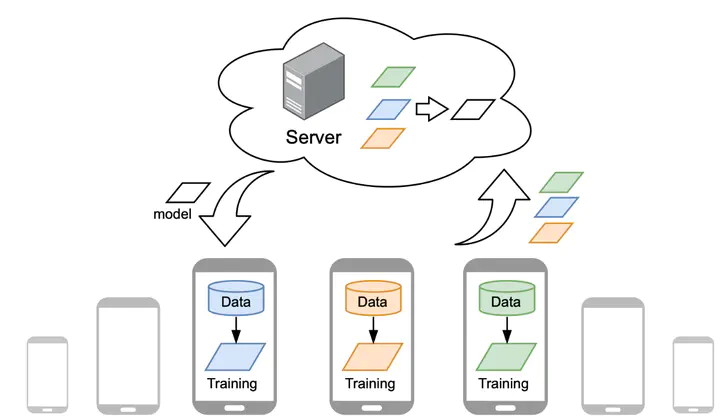


In [ ]:
# FL setup

# Declare the model
def model(input_shape, min_val, max_val):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    classifier = KerasClassifier(clip_values=(min_val, max_val),model=model, use_logits=False)
    return classifier

# Perform FED-AVG
def aggregated_weights(client1_weights,client2_weights):
    new_weights = []
    for w_client1, w_client2 in zip(client1_weights, client2_weights):
        avg_weight = (w_client1 + w_client2) / 2.0
        new_weights.append(avg_weight)
    return new_weights

# Initialize the model
# Client1
client1_model = model(x_train_set1.shape[1:], 0, 1)
# Client2
client2_model = model(x_train_set2.shape[1:], 0, 1)
# Converged model
converged_model = model(x_train_set1.shape[1:], 0, 1)

for round_num in range(5):
    print(f"Communication Round {round_num + 1}")

    # Train the model
    # Client 1 trains locally
    client1_model.fit(x_train_set1, y_train_set1, nb_epochs=5, batch_size=128, verbose=0)
    # Client 2 trains locally
    client2_model.fit(x_train_set2, y_train_set2, nb_epochs=5, batch_size=128, verbose=0)

    # Test the model
    # Client1
    predictions_set1 = client1_model.predict(x_test_set1)
    predicted_labels_set1 = np.argmax(predictions_set1, axis=1)  # Convert probabilities to class labels
    accuracy_set1 = np.mean(predicted_labels_set1 == np.argmax(y_test_set1, axis=1))
    print(f"Test Set 1 - Accuracy: {accuracy_set1:.4f}")
    # Client2
    predictions_set2 = client2_model.predict(x_test_set2)
    predicted_labels_set2 = np.argmax(predictions_set2, axis=1)  # Convert probabilities to class labels
    accuracy_set1 = np.mean(predicted_labels_set2 == np.argmax(y_test_set2, axis=1))
    print(f"Test Set 2 - Accuracy: {accuracy_set1:.4f}")

    # Combine weights
    # Get client weights
    # Get client 1's and client 2's weights
    client1_weights = client1_model.model.get_weights()
    client2_weights = client2_model.model.get_weights()
    # FedAvg: Average the weights of both clients
    new_weights=aggregated_weights(client1_weights,client2_weights)
    # Update both models with the averaged weights (synchronizing them)
    client1_model.model.set_weights(new_weights)
    client2_model.model.set_weights(new_weights)

    # Converged model
    converged_model.model.set_weights(new_weights)
    predictions_set0 = converged_model.predict(x_test_set1) # Client1 test set
    predicted_labels_set0 = np.argmax(predictions_set0, axis=1) # Convert probabilities to class labels
    predictions_set1 = converged_model.predict(x_test_set2) # Client2 test set
    predicted_labels_set1 = np.argmax(predictions_set1, axis=1)
    accuracy_set0 = np.mean(predicted_labels_set0 == np.argmax(y_test_set1, axis=1))
    print(f"Converged model on client1 test set: {accuracy_set0:.4f}")
    accuracy_set1 = np.mean(predicted_labels_set1 == np.argmax(y_test_set2, axis=1))
    print(f"Converged model on client2 test set: {accuracy_set1:.4f}")

Communication Round 1
Test Set 1 - Accuracy: 0.9955
Test Set 2 - Accuracy: 0.9909
Converged model on client1 test set: 0.4121
Converged model on client2 test set: 0.6558
Communication Round 2
Test Set 1 - Accuracy: 0.9975
Test Set 2 - Accuracy: 0.9928
Converged model on client1 test set: 0.9502
Converged model on client2 test set: 0.8945
Communication Round 3
Test Set 1 - Accuracy: 0.9984
Test Set 2 - Accuracy: 0.9940
Converged model on client1 test set: 0.9482
Converged model on client2 test set: 0.9747
Communication Round 4
Test Set 1 - Accuracy: 0.9977
Test Set 2 - Accuracy: 0.9944
Converged model on client1 test set: 0.9803
Converged model on client2 test set: 0.9107
Communication Round 5
Test Set 1 - Accuracy: 0.9973
Test Set 2 - Accuracy: 0.9942
Converged model on client1 test set: 0.9488
Converged model on client2 test set: 0.9743


In [ ]:
# Round 6 - Attack State

# Train the model
# Client 1 trains locally
client1_model.fit(x_train_set1, y_train_set1, nb_epochs=5, batch_size=128, verbose=0)
# Client 2 trains locally
client2_model.fit(x_train_set2, y_train_set2, nb_epochs=5, batch_size=128, verbose=0)


# **PART2: Perform MIA Attack**
Here we have initialized set of samples and observed attack performance on each sample. And also we have observed gradient variations on these samples. The samples initialized are: Black Image, White Image, Grey Image, Random Image, Average Image.
- We would also apply MIA attack on client1 model, client2 model and converged model, and analyze the attack

Minimum over all maximum class gradient: 0.008187


Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Minimum over all maximum class gradient: 0.004201


Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Minimum over all maximum class gradient: 0.010643


Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Minimum over all maximum class gradient: 0.008285


Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Minimum over all maximum class gradient: 0.022610


Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

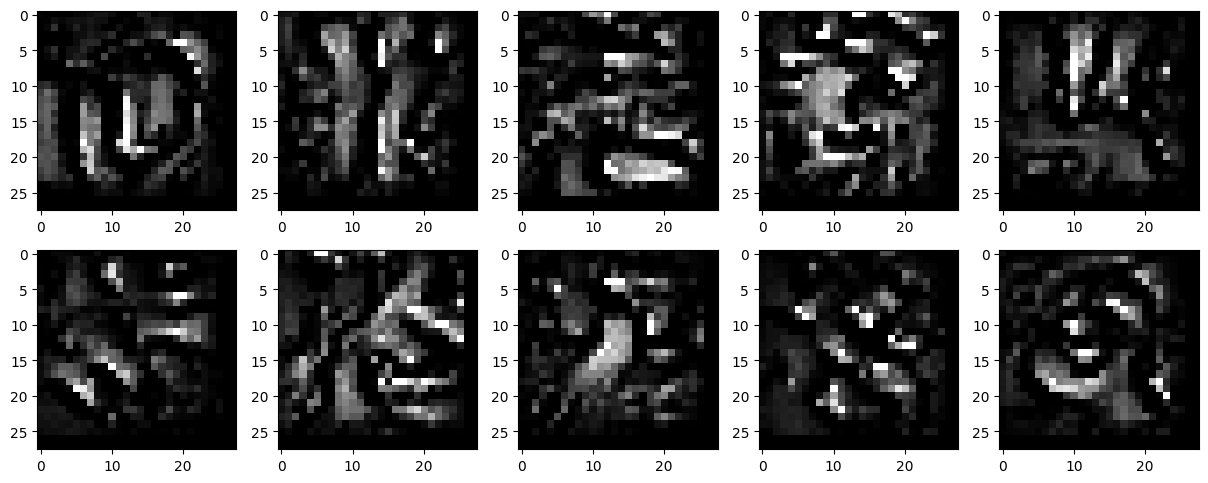

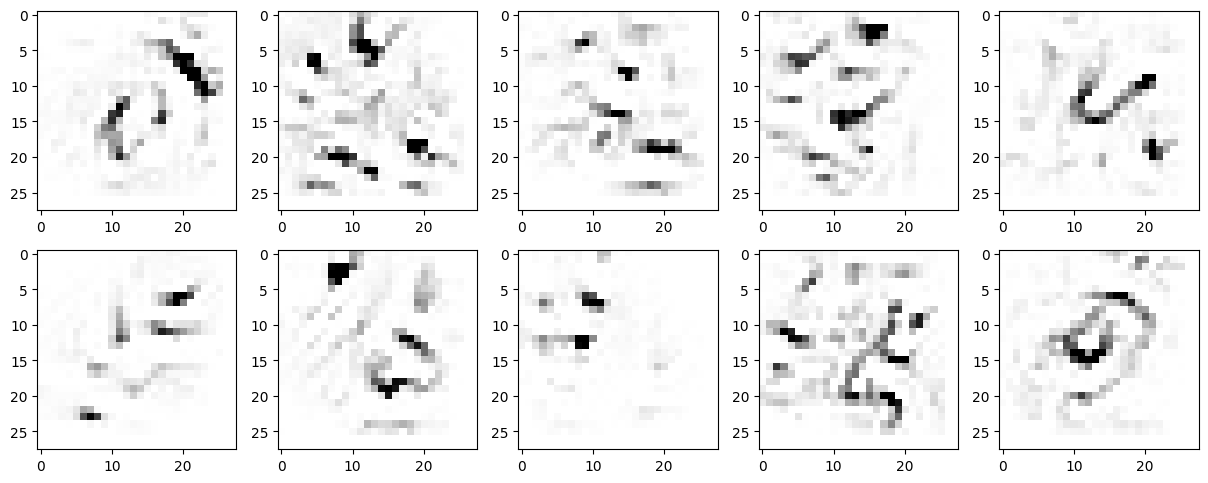

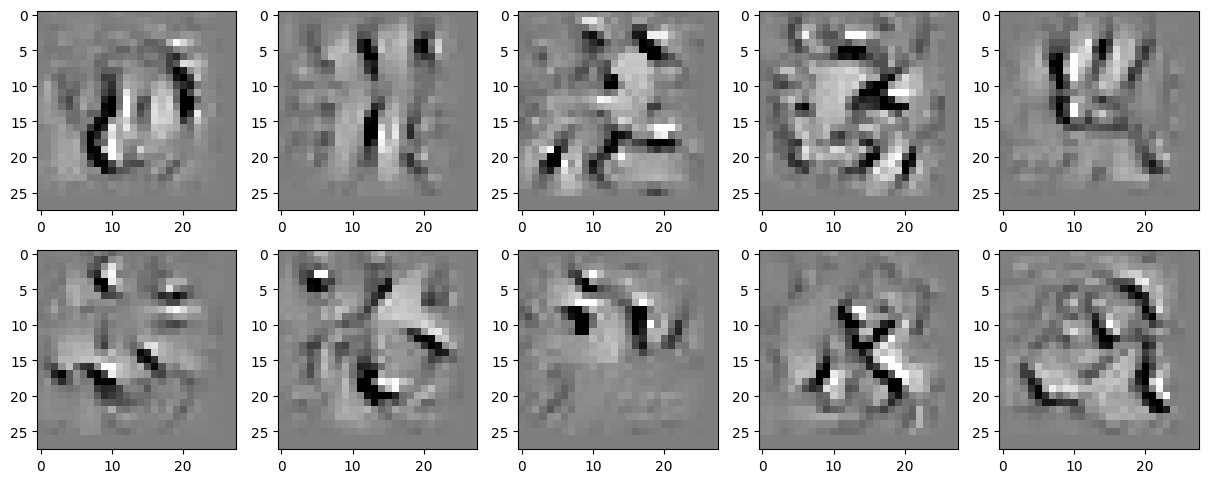

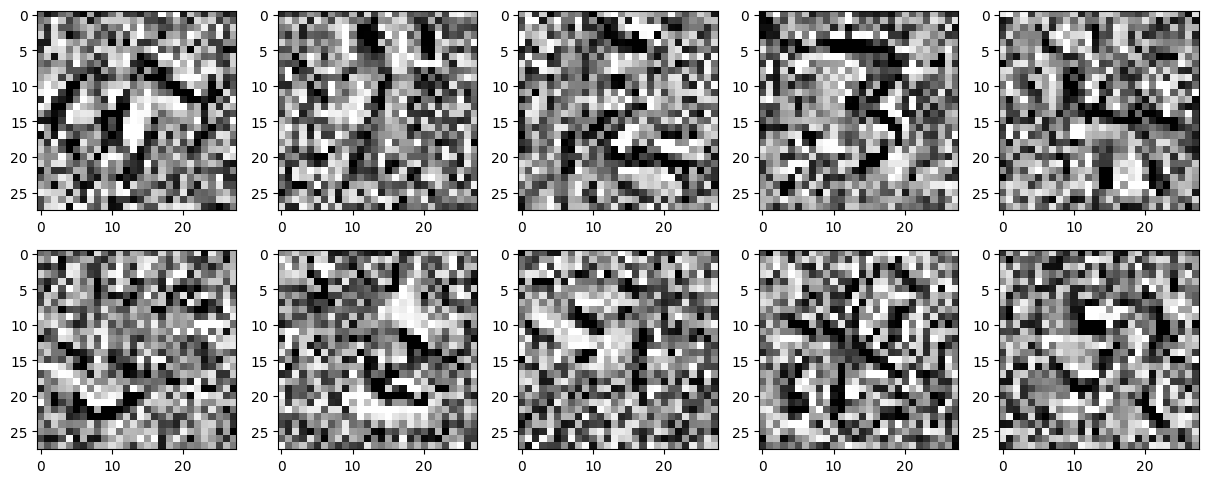

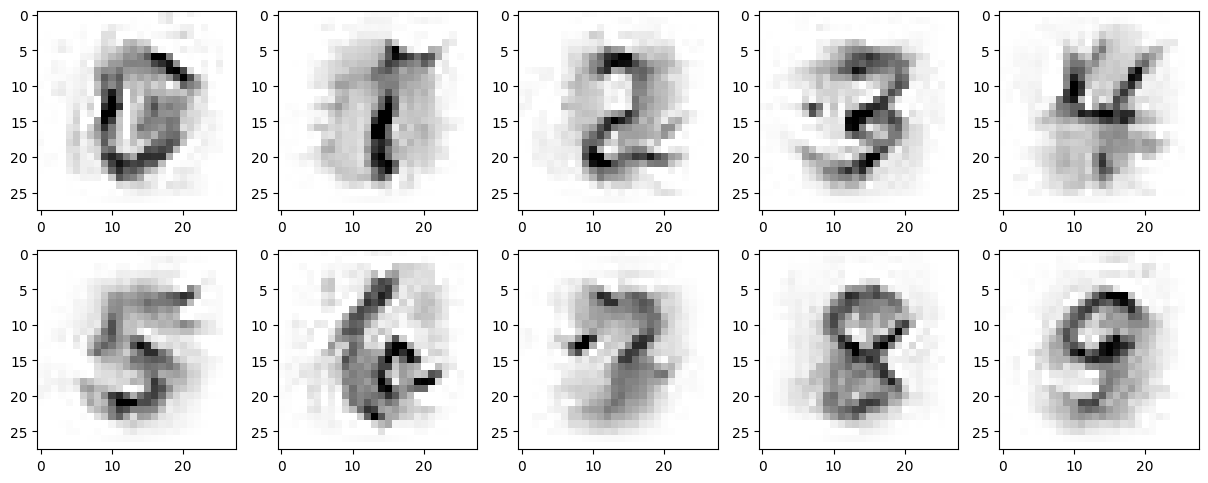

In [ ]:
# Model Inversion Attack on Converged model

# Create the attack
attack = MIFace(converged_model, max_iter=20000, threshold=1.5)
# for each 10 MNIST classes
y = np.arange(10)


# Experiment on Black Sample
x_init_black = np.ones((10, 28, 28, 1))
# Calculate the gradient
class_gradient = converged_model.class_gradient(x_init_black, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)
print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))
# Run the attack
x_infer_from_black = attack.infer(x_init_black, y)
# Plot the inferred images:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_black[0+i,], (28, 28))), cmap=plt.cm.gray_r)


# Experiment on White Sample
x_init_white = np.zeros((10, 28, 28, 1))
# Calculate the gradient
class_gradient = converged_model.class_gradient(x_init_white, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)
print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))
# Run the attack
x_infer_from_white = attack.infer(x_init_white, y)
# Plot the inferred images:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_white[0+i,], (28, 28))), cmap=plt.cm.gray_r)


# Experiment on Grey Sample
x_init_grey = np.zeros((10, 28, 28, 1)) + 0.5
# Calculate the gradient
class_gradient = converged_model.class_gradient(x_init_grey, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)
print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))
# Run the attack
x_infer_from_grey = attack.infer(x_init_grey, y)
# Plot the inferred images:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_grey[0+i,], (28, 28))), cmap=plt.cm.gray_r)


# Experiment on Random Sample
x_init_random = np.random.uniform(0, 1, (10, 28, 28, 1))
# Calculate the gradient
class_gradient = converged_model.class_gradient(x_init_random, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)
print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))
# Run the attack
x_infer_from_random = attack.infer(x_init_random, y)
# Plot the inferred images:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_random[0+i,], (28, 28))), cmap=plt.cm.gray_r)


# Experiment on Average Sample
x_init_average = np.zeros((10, 28, 28, 1)) + np.mean(x_test, axis=0)
# Calculate the gradient
class_gradient = converged_model.class_gradient(x_init_average, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)
print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))
# Run the attack
x_infer_from_average = attack.infer(x_init_average, y)
# Plot the inferred images:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_average[0+i,], (28, 28))), cmap=plt.cm.gray_r)

Minimum over all maximum class gradient: 0.005707


Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Minimum over all maximum class gradient: 0.000000


Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Minimum over all maximum class gradient: 0.013450


Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Minimum over all maximum class gradient: 0.014532


Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Minimum over all maximum class gradient: 0.013476


Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

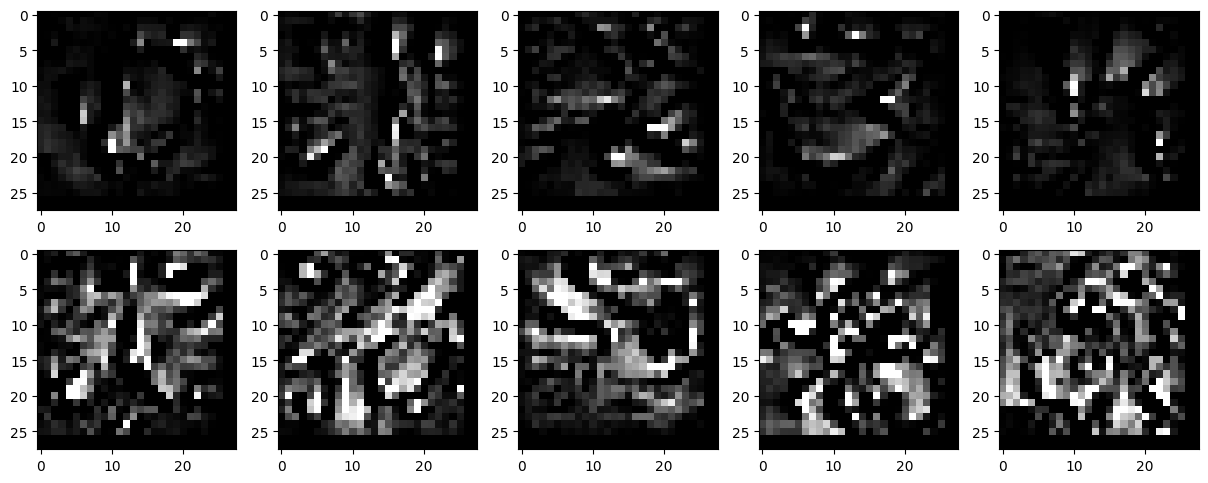

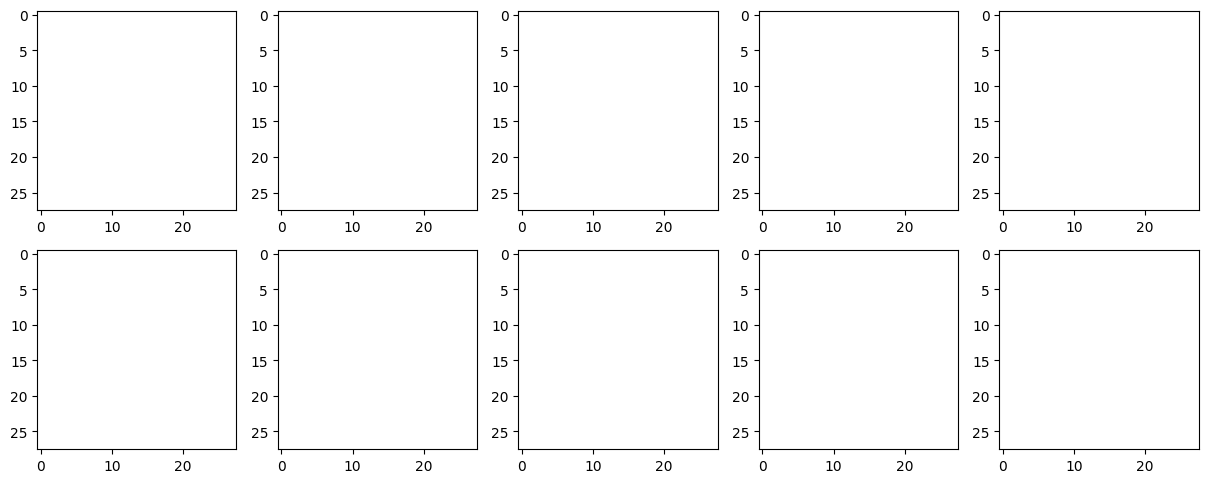

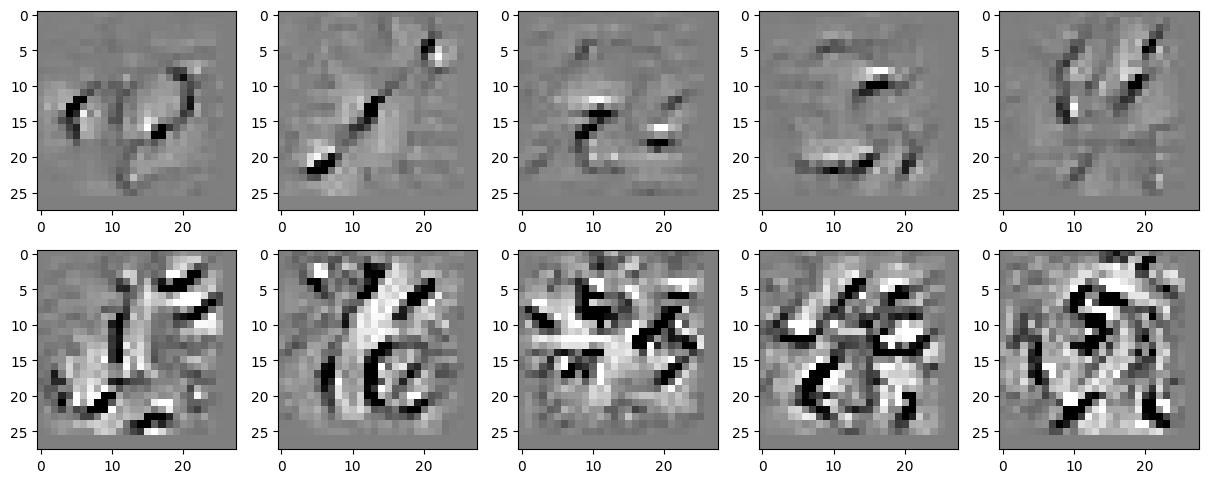

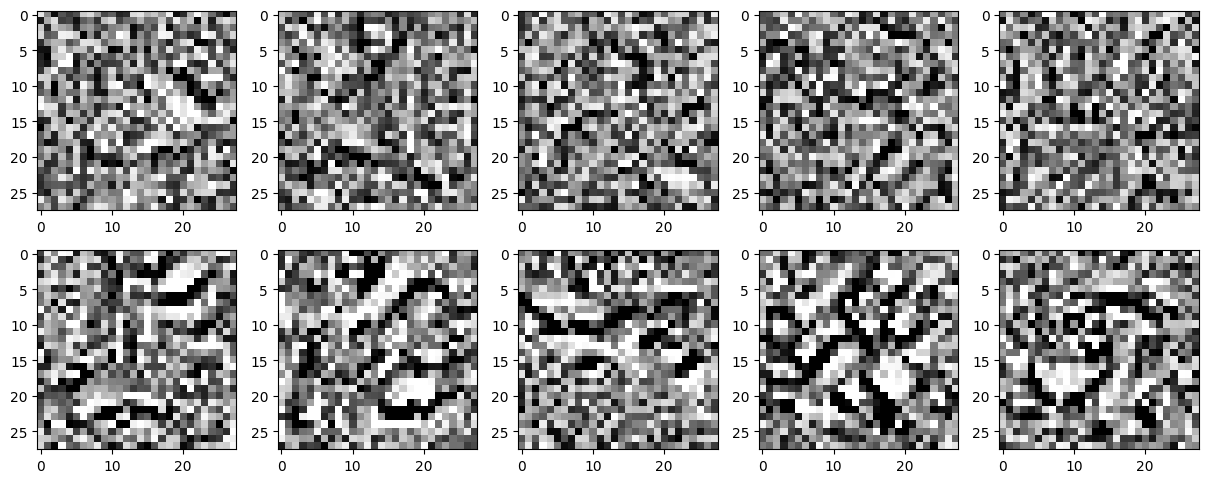

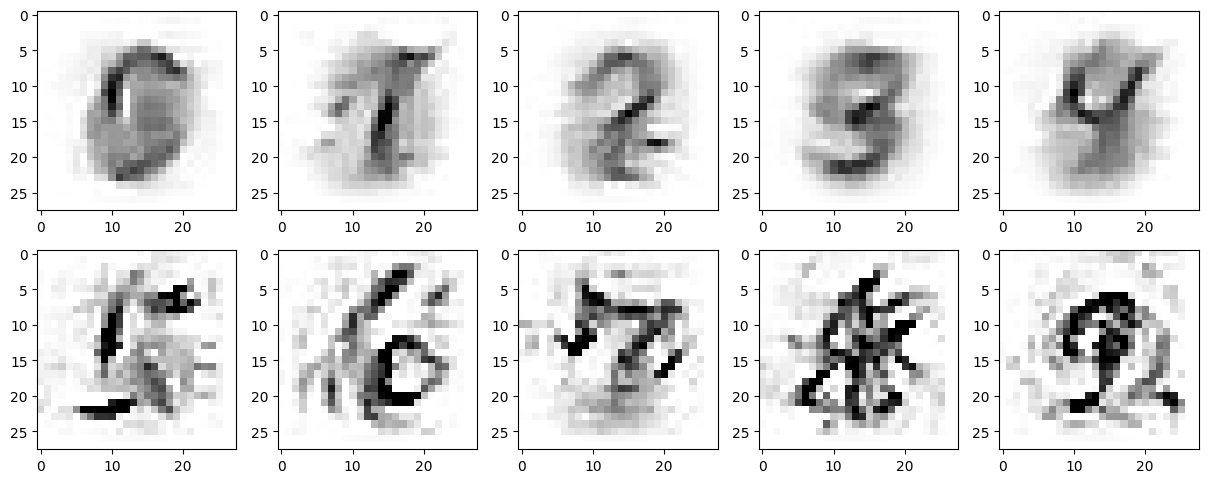

In [ ]:
# Model Inversion Attack on client1 model

# Create the attack
attack = MIFace(client1_model, max_iter=20000, threshold=1.5)
# for each 10 MNIST classes
y = np.arange(10)


# Experiment on Black Sample
x_init_black = np.ones((10, 28, 28, 1))
# Calculate the gradient
class_gradient = client1_model.class_gradient(x_init_black, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)
print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))
# Run the attack
x_infer_from_black = attack.infer(x_init_black, y)
# Plot the inferred images:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_black[0+i,], (28, 28))), cmap=plt.cm.gray_r)


# Experiment on White Sample
x_init_white = np.zeros((10, 28, 28, 1))
# Calculate the gradient
class_gradient = client1_model.class_gradient(x_init_white, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)
print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))
# Run the attack
x_infer_from_white = attack.infer(x_init_white, y)
# Plot the inferred images:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_white[0+i,], (28, 28))), cmap=plt.cm.gray_r)


# Experiment on Grey Sample
x_init_grey = np.zeros((10, 28, 28, 1)) + 0.5
# Calculate the gradient
class_gradient = client1_model.class_gradient(x_init_grey, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)
print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))
# Run the attack
x_infer_from_grey = attack.infer(x_init_grey, y)
# Plot the inferred images:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_grey[0+i,], (28, 28))), cmap=plt.cm.gray_r)


# Experiment on Random Sample
x_init_random = np.random.uniform(0, 1, (10, 28, 28, 1))
# Calculate the gradient
class_gradient = client1_model.class_gradient(x_init_random, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)
print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))
# Run the attack
x_infer_from_random = attack.infer(x_init_random, y)
# Plot the inferred images:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_random[0+i,], (28, 28))), cmap=plt.cm.gray_r)


# Experiment on Average Sample
x_init_average = np.zeros((10, 28, 28, 1)) + np.mean(x_test, axis=0)
# Calculate the gradient
class_gradient = client1_model.class_gradient(x_init_average, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)
print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))
# Run the attack
x_infer_from_average = attack.infer(x_init_average, y)
# Plot the inferred images:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_average[0+i,], (28, 28))), cmap=plt.cm.gray_r)

Minimum over all maximum class gradient: 0.002092


Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Minimum over all maximum class gradient: 0.007354


Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Minimum over all maximum class gradient: 0.008863


Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Minimum over all maximum class gradient: 0.004769


Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Minimum over all maximum class gradient: 0.016181


Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

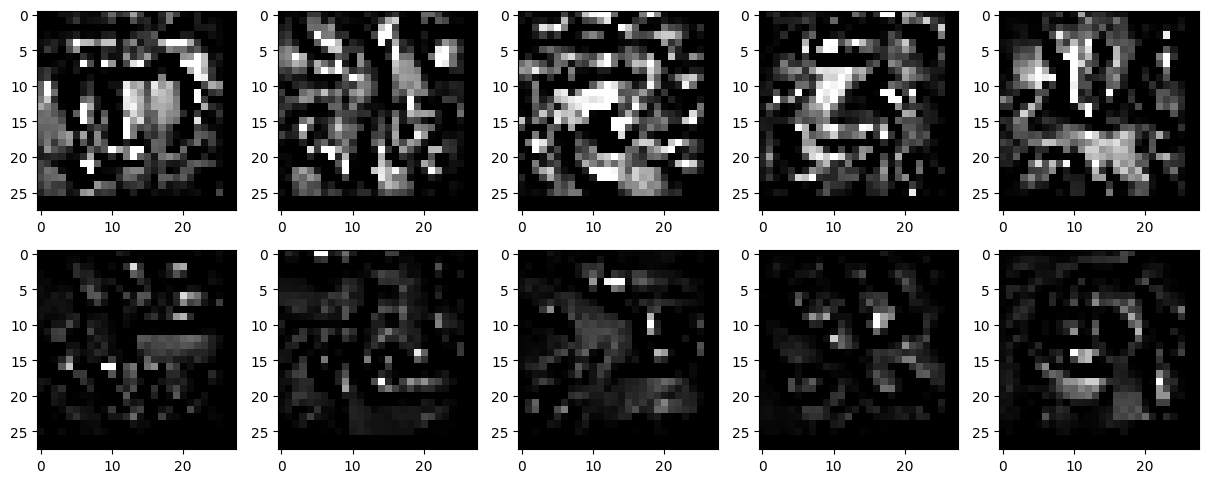

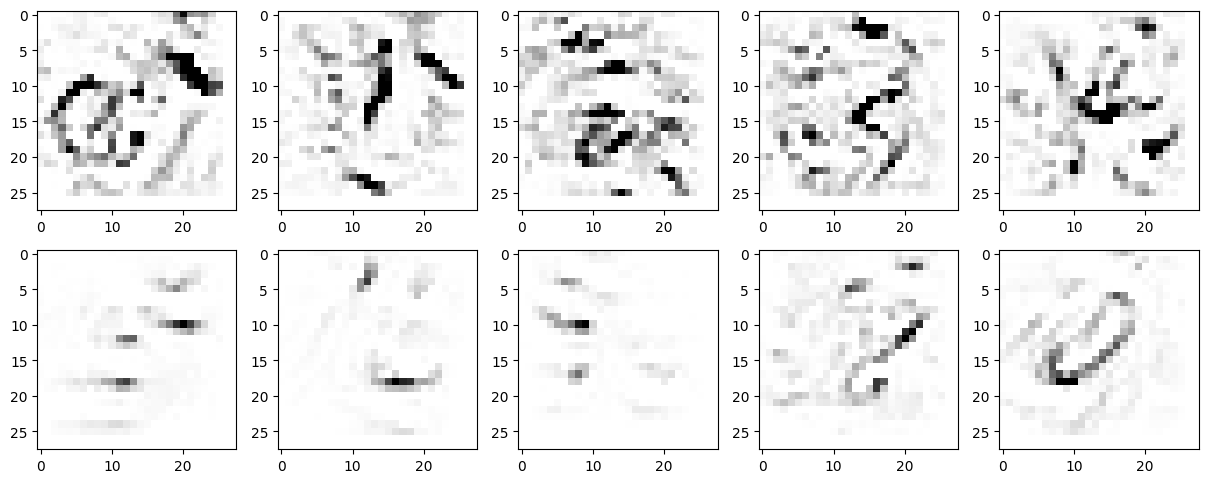

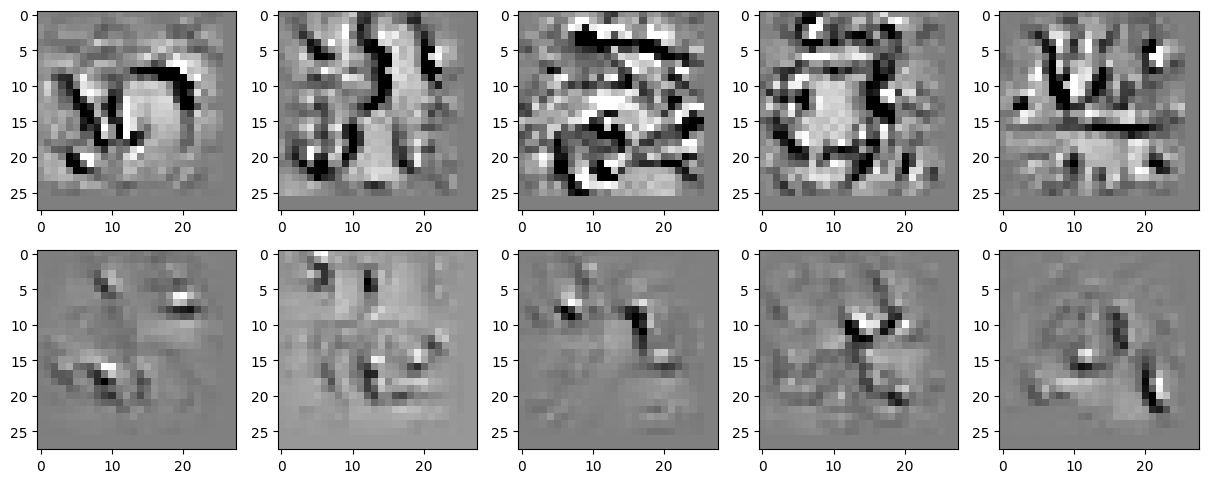

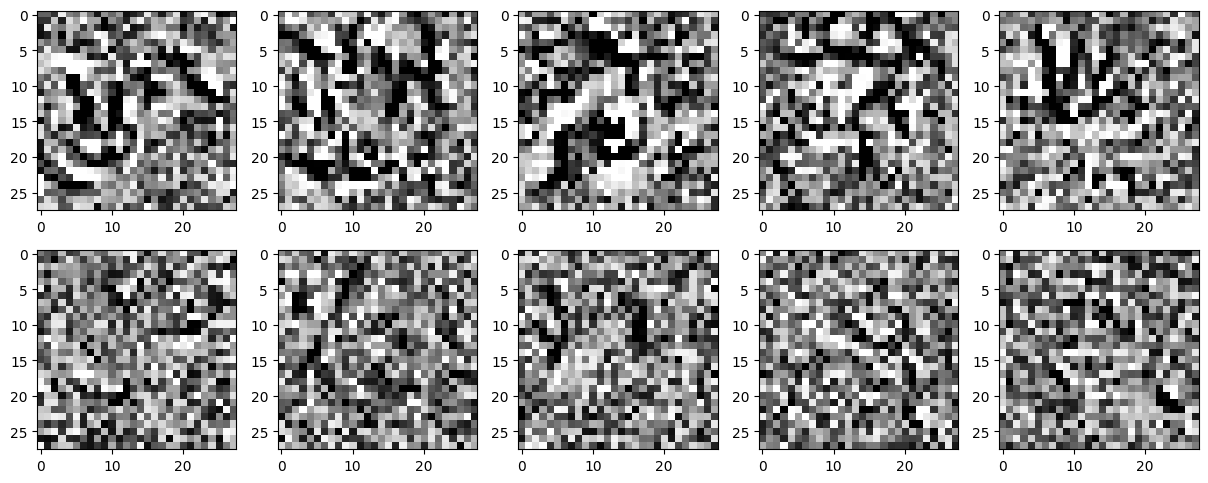

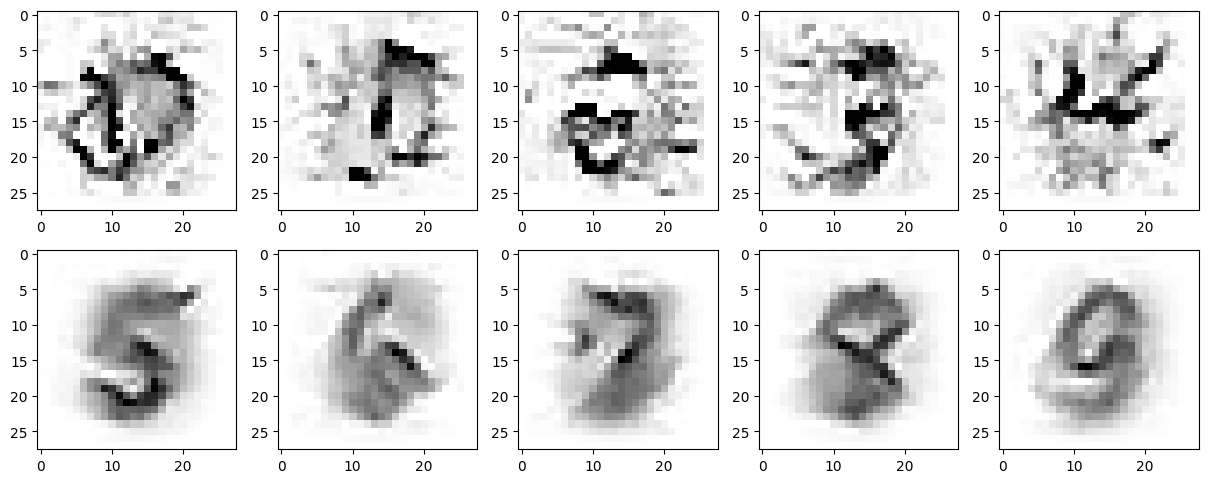

In [ ]:
# Model Inversion Attack on client2 model

# Create the attack
attack = MIFace(client2_model, max_iter=20000, threshold=1.5)
# for each 10 MNIST classes
y = np.arange(10)


# Experiment on Black Sample
x_init_black = np.ones((10, 28, 28, 1))
# Calculate the gradient
class_gradient = client2_model.class_gradient(x_init_black, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)
print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))
# Run the attack
x_infer_from_black = attack.infer(x_init_black, y)
# Plot the inferred images:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_black[0+i,], (28, 28))), cmap=plt.cm.gray_r)


# Experiment on White Sample
x_init_white = np.zeros((10, 28, 28, 1))
# Calculate the gradient
class_gradient = client2_model.class_gradient(x_init_white, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)
print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))
# Run the attack
x_infer_from_white = attack.infer(x_init_white, y)
# Plot the inferred images:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_white[0+i,], (28, 28))), cmap=plt.cm.gray_r)


# Experiment on Grey Sample
x_init_grey = np.zeros((10, 28, 28, 1)) + 0.5
# Calculate the gradient
class_gradient = client2_model.class_gradient(x_init_grey, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)
print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))
# Run the attack
x_infer_from_grey = attack.infer(x_init_grey, y)
# Plot the inferred images:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_grey[0+i,], (28, 28))), cmap=plt.cm.gray_r)


# Experiment on Random Sample
x_init_random = np.random.uniform(0, 1, (10, 28, 28, 1))
# Calculate the gradient
class_gradient = client2_model.class_gradient(x_init_random, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)
print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))
# Run the attack
x_infer_from_random = attack.infer(x_init_random, y)
# Plot the inferred images:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_random[0+i,], (28, 28))), cmap=plt.cm.gray_r)


# Experiment on Average Sample
x_init_average = np.zeros((10, 28, 28, 1)) + np.mean(x_test, axis=0)
# Calculate the gradient
class_gradient = client2_model.class_gradient(x_init_average, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)
print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))
# Run the attack
x_infer_from_average = attack.infer(x_init_average, y)
# Plot the inferred images:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_average[0+i,], (28, 28))), cmap=plt.cm.gray_r)

# **Part3: Perform MIA Attack - at different thresholds**




Minimum over all maximum class gradient: 0.022610


Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

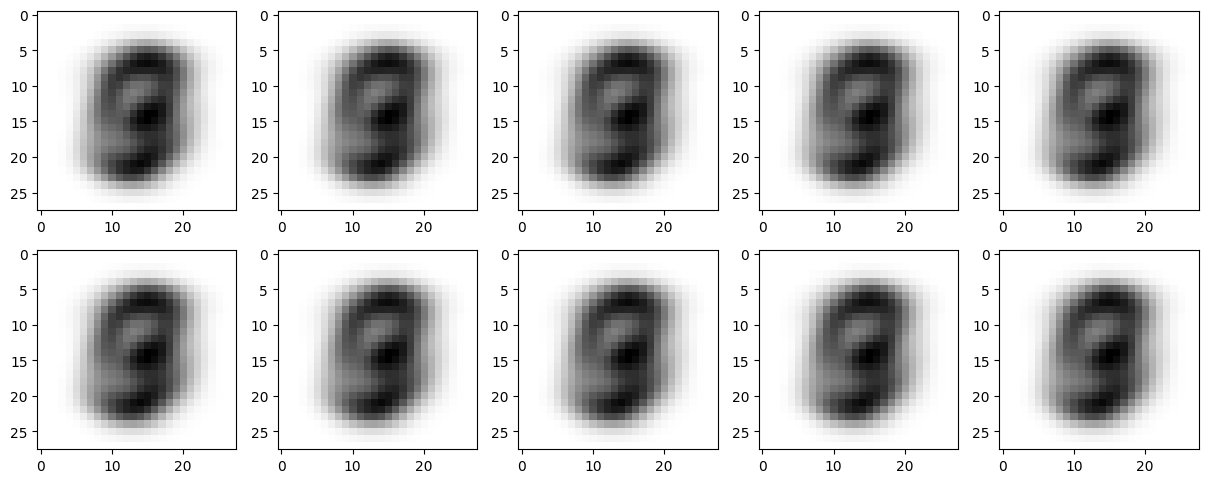

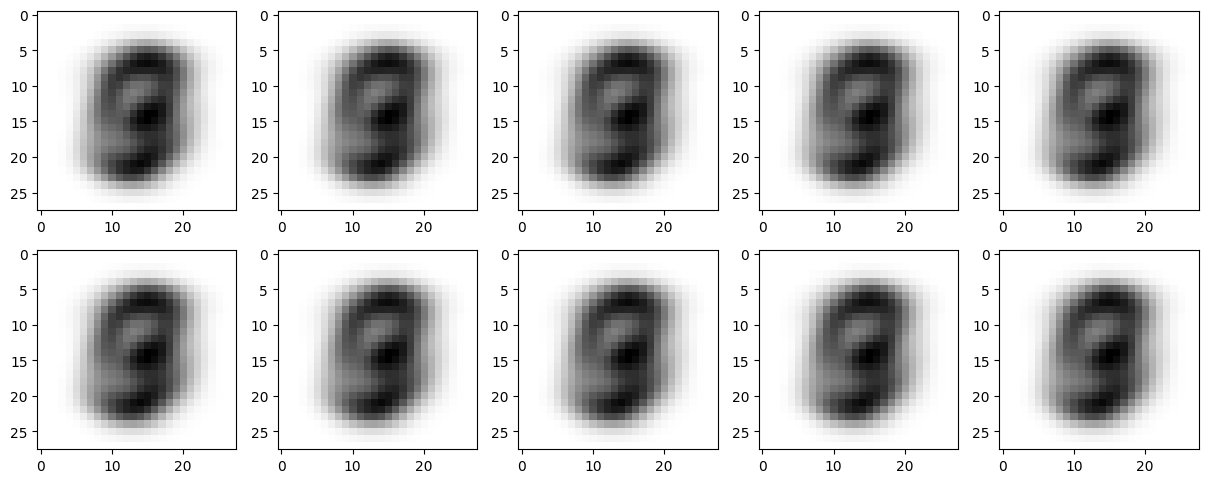

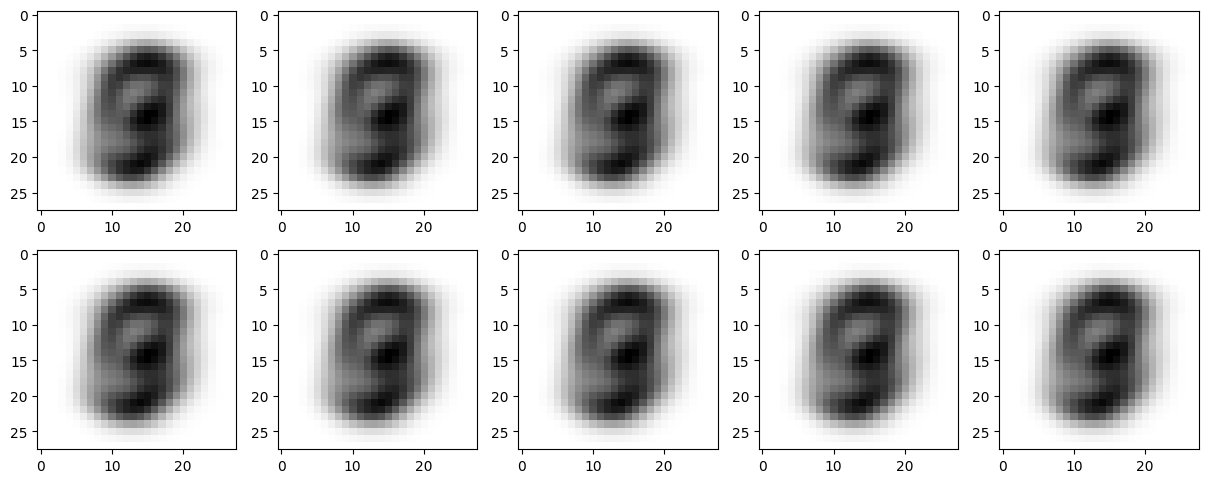

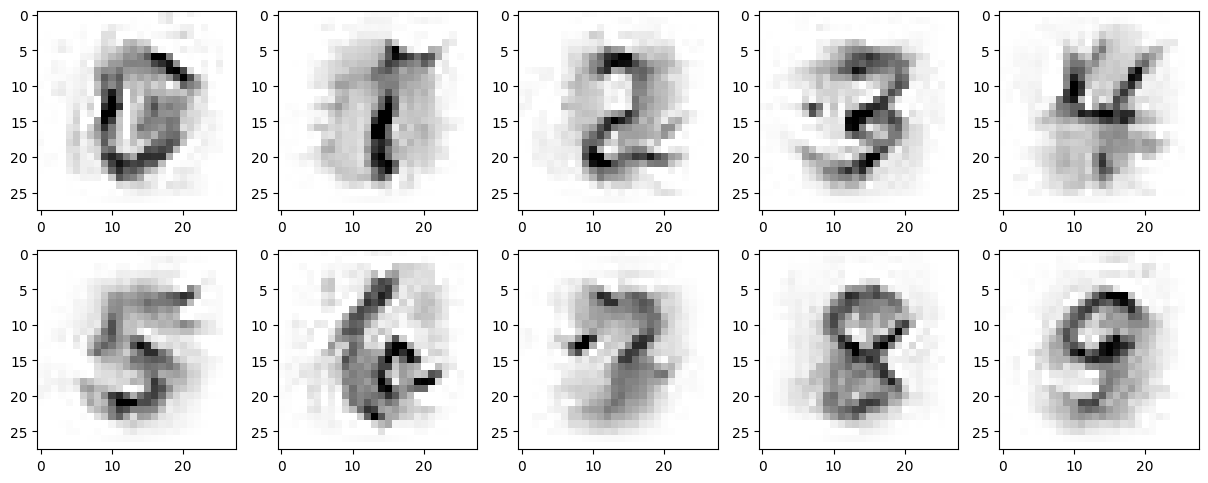

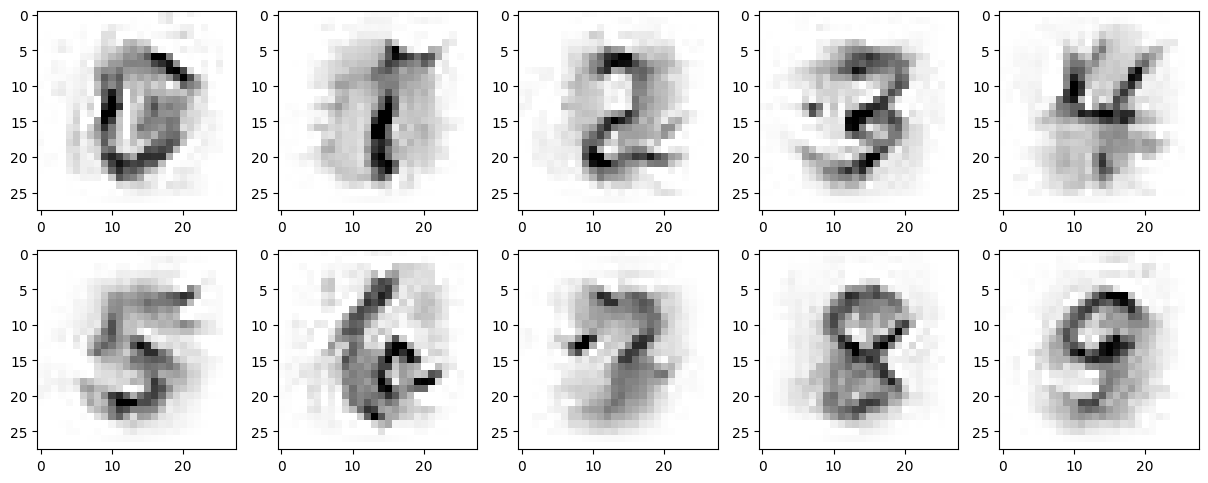

In [ ]:
# Experiment MIA at different thresholds

# different threshold values
threshold_values = [0.1,0.2,0.5,1.,1.5]
# for each 10 MNIST classes
y = np.arange(10)
# Experiment on Average Sample
x_init_average = np.zeros((10, 28, 28, 1)) + np.mean(x_test, axis=0)
# Calculate the gradient
class_gradient = converged_model.class_gradient(x_init_average, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)
print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))

for t in threshold_values:
    # Create the attack
    attack = MIFace(converged_model, max_iter=20000, threshold=t)
    # Run the attack
    x_infer_from_average = attack.infer(x_init_average, y)
    # Plot the inferred images:
    plt.figure(figsize=(15,15))
    for i in range(10):
        plt.subplot(5, 5, i + 1)
        plt.imshow( (np.reshape(x_infer_from_average[0+i,], (28, 28))), cmap=plt.cm.gray_r)

# **Part4: Perform MIA Attack - at different iterations**

Minimum over all maximum class gradient: 0.022610


Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

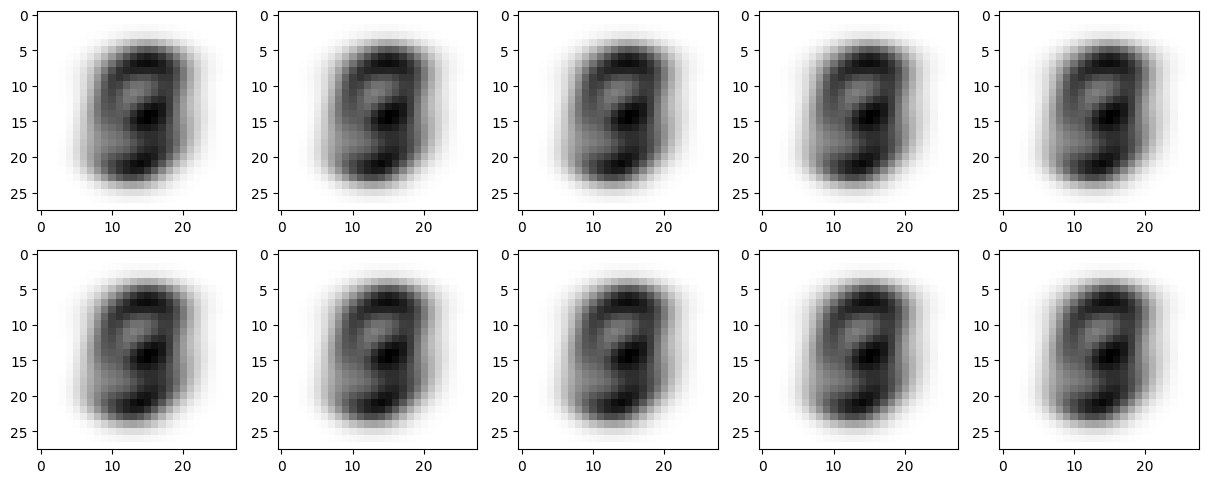

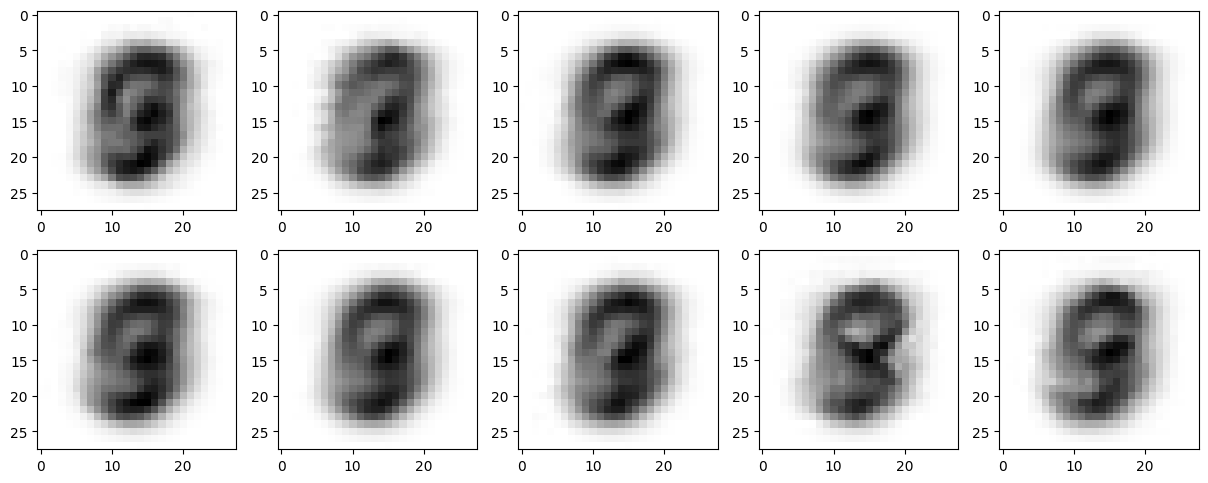

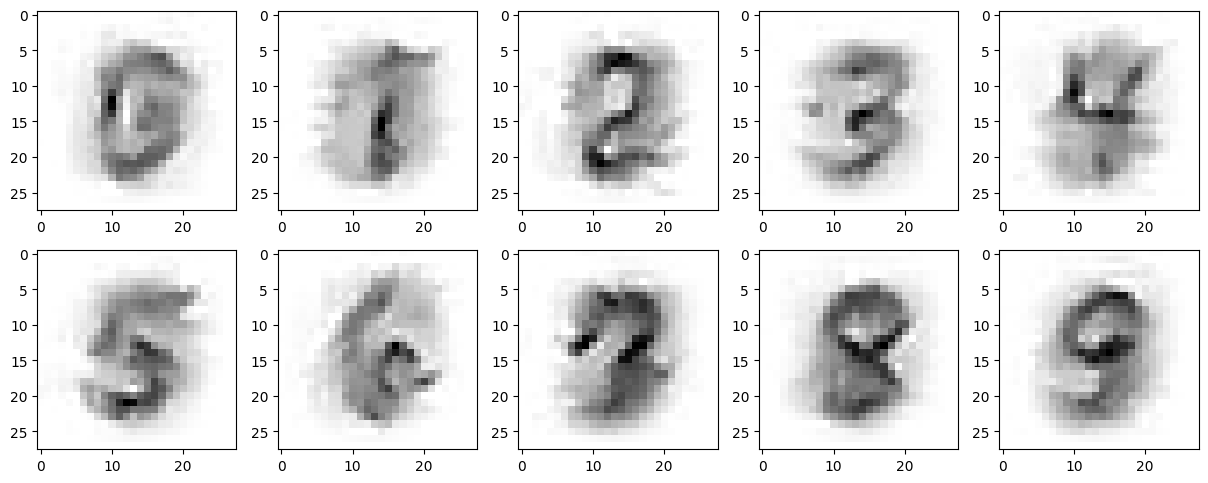

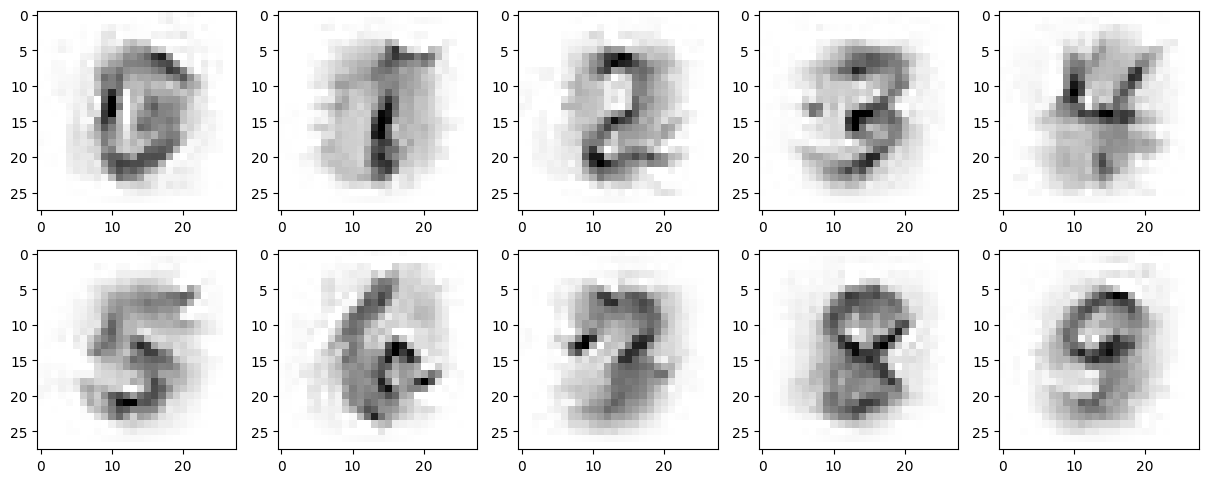

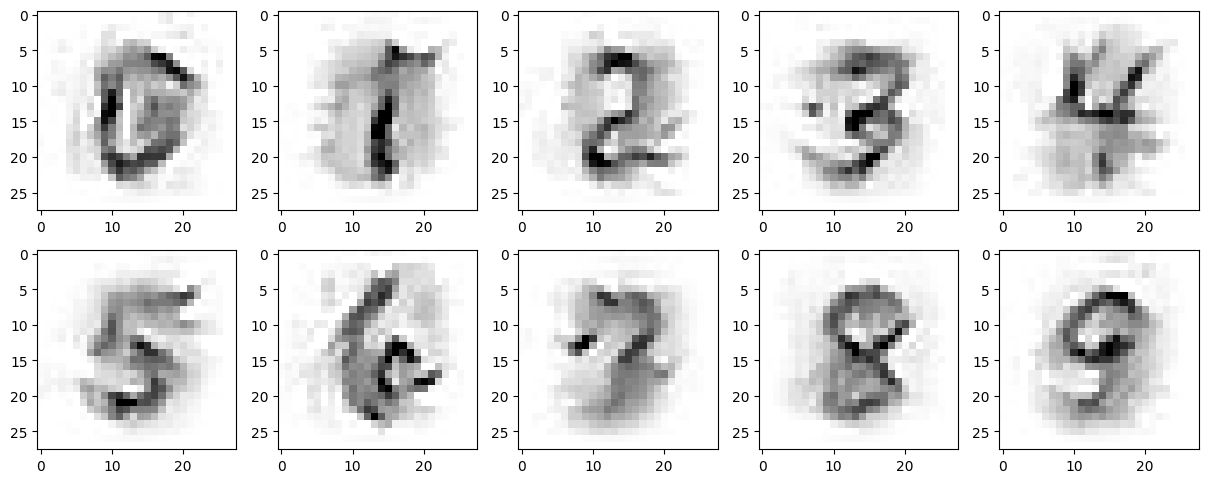

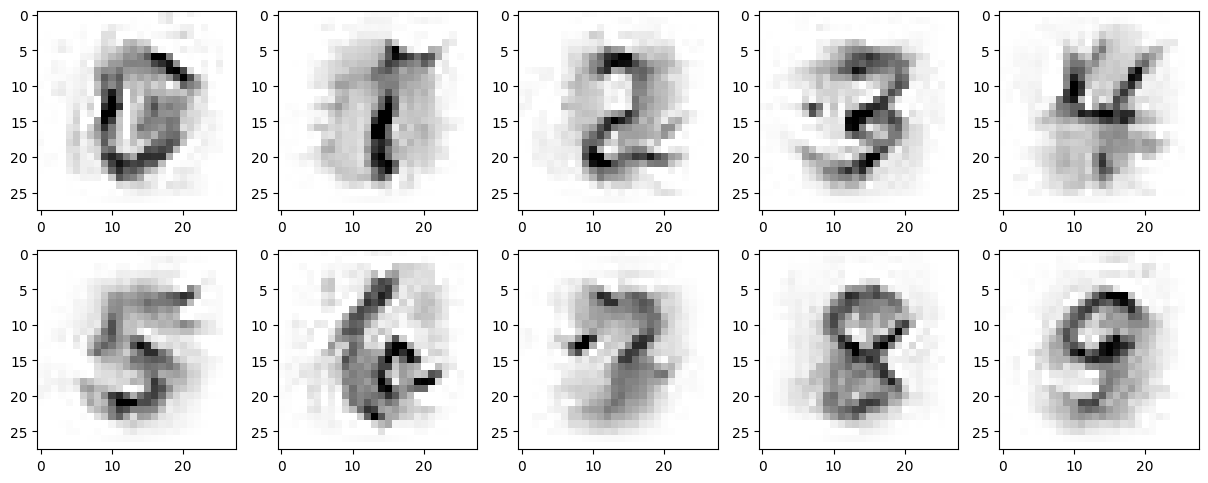

In [ ]:
# Experiment MIA at different thresholds

# different threshold values
num_iterations = [0,10,100,1000,10000,20000]
# for each 10 MNIST classes
y = np.arange(10)
# Experiment on Average Sample
x_init_average = np.zeros((10, 28, 28, 1)) + np.mean(x_test, axis=0)
# Calculate the gradient
class_gradient = converged_model.class_gradient(x_init_average, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)
print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))

for i in num_iterations:
    # Create the attack
    attack = MIFace(converged_model, max_iter=i, threshold=1.5)
    # Run the attack
    x_infer_from_average = attack.infer(x_init_average, y)
    # Plot the inferred images:
    plt.figure(figsize=(15,15))
    for i in range(10):
        plt.subplot(5, 5, i + 1)
        plt.imshow( (np.reshape(x_infer_from_average[0+i,], (28, 28))), cmap=plt.cm.gray_r)